# Inhibitor Diffusion and Germination - Julia Procedures

## Numerical experiments - Week 03/2025

_Boyan Mihaylov, MSc Computational Science (UVA/VU)_

## Prerequisite libraries

With rising complexity of the simulations, performance issues need to be tackled. For this reason, a comparative study of a diffusion solver programmed in Julia is compared to its equivalent in Python.

In [1]:
using Pkg
Pkg.add("CUDA")

    Updating registry at `C:\Users\mihbo\.julia\registries\General.toml`
   Resolving package versions...
   Installed BFloat16s ────────────── v0.5.0
   Installed LLVMLoopInfo ─────────── v1.0.0
   Installed NVTX_jll ─────────────── v3.1.0+2
   Installed TimerOutputs ─────────── v0.5.26
   Installed CUDA_Runtime_jll ─────── v0.15.5+0
   Installed demumble_jll ─────────── v1.3.0+0
   Installed CUDA_Driver_jll ──────── v0.10.4+0
   Installed RandomNumbers ────────── v1.6.0
   Installed GPUArrays ────────────── v10.3.1
   Installed CUDA_Runtime_Discovery ─ v0.3.5
   Installed LLVM ─────────────────── v9.1.3
   Installed ExprTools ────────────── v0.1.10
   Installed NVTX ─────────────────── v0.3.5
   Installed Random123 ────────────── v1.7.0
   Installed LLVMExtra_jll ────────── v0.0.34+0
   Installed UnsafeAtomics ────────── v0.3.0
   Installed GPUArraysCore ────────── v0.1.6
   Installed Atomix ───────────────── v1.0.1
   Installed KernelAbstractions ───── v0.9.31
   Installed JuliaNVTX

In [10]:
using CUDA
CUDA.versioninfo()

using Test

CUDA runtime 12.6, artifact installation
CUDA driver 12.4
NVIDIA driver 553.50.0

CUDA libraries: 
- CUBLAS: 12.6.4
- CURAND: 10.3.7
- CUFFT: 11.3.0
- CUSOLVER: 11.7.1
- CUSPARSE: 12.5.4
- CUPTI: 2024.3.2 (API 24.0.0)
- NVML: 12.0.0+553.50

Julia packages: 
- CUDA: 5.5.2
- CUDA_Driver_jll: 0.10.4+0
- CUDA_Runtime_jll: 0.15.5+0

Toolchain:
- Julia: 1.10.5
- LLVM: 15.0.7

1 device:
  0: NVIDIA RTX 2000 Ada Generation Laptop GPU (sm_89, 7.651 GiB / 7.996 GiB available)


In [45]:
function invoke_smart_kernel_3D(size, threads_per_block=(8, 8, 8))
    """
    Invoke a kernel with the appropriate number of blocks and threads per block.
    """
    blocks_per_grid = (Int(ceil(size[1] / threads_per_block[1])),
                       Int(ceil(size[2] / threads_per_block[2])),
                       Int(ceil(size[3] / threads_per_block[3])))
    return blocks_per_grid, threads_per_block
end

function update_GPU(c_old, c_new, Ddtdx2)
    """
    Update the concentration values on the lattice
    using the time-dependent diffusion equation.
    """
    i, j, k = CUDA.blockIdx().x, CUDA.blockIdx().y, CUDA.blockIdx().z
    ti, tj, tk = CUDA.threadIdx().x, CUDA.threadIdx().y, CUDA.threadIdx().z

    # Determine the size of the lattice
    N = size(c_old, 1)

    # Determine the indices of the current cell
    idx = (i * blockDim().x + ti, j * blockDim().y + tj, k * blockDim().z + tk)

    # Update the concentration value
    if 2 ≤ idx[1] ≤ N - 1 && 2 ≤ idx[2] ≤ N - 1 && 2 ≤ idx[3] ≤ N - 1
        c_new[idx...] = c_old[idx...] + Ddtdx2 * (c_old[idx[1] + 1, idx[2], idx[3]] + c_old[idx[1] - 1, idx[2], idx[3]] +
                                                  c_old[idx[1], idx[2] + 1, idx[3]] + c_old[idx[1], idx[2] - 1, idx[3]] +
                                                  c_old[idx[1], idx[2], idx[3] + 1] + c_old[idx[1], idx[2], idx[3] - 1] - 6 * c_old[idx...])
    end

    return nothing
end

function diffusion_time_dependent_GPU(c_init, t_max, D=1.0, dt=0.001, dx=0.005)
    """
    Compute the evolution of a 3D cubic lattice of concentration scalars
    based on the time-dependent diffusion equation.
    inputs:
        c_init (array) - the initial state of the lattice;
        t_max (int) - a maximum number of iterations;
        D (float) - the diffusion constant; defaults to 1;
        dt (float) - timestep; defaults to 0.001;
        dx (float) - spatial increment; defaults to 0.005;
    outputs:
        u_evolotion (array) - the states of the lattice at all moments in time.
    """

    # Determine number of lattice rows/columns
    N = size(c_init, 1)

    # Save update factor
    dtdx2 = dt / (dx ^ 2)

    if D * dtdx2 > 0.5
        @warn "Unstable solution: D * dt / dx^2 = $(D * dtdx2) > 0.5"
    end

    # Determine number of frames
    n_frames = floor(Int, t_max / dt)
    println("Simulation running for ", n_frames, " steps on a lattice of size ", size(c_init) .* dx, " microns.")

    # Initialize lattice on diffusion_time_dependent_GPU
    c_A_gpu = cu(c_init)
    c_B_gpu = CUDA.zeros(N, N, N)

    kernel_blocks, kernel_threads = invoke_smart_kernel_3D(size(c_init))

    # Run the simulation
    for t in 1:n_frames
        # Update the lattice
        @cuda threads=kernel_threads blocks=kernel_blocks update_GPU(c_A_gpu, c_B_gpu, dtdx2)
        c_A_gpu, c_B_gpu = c_B_gpu, c_A_gpu
    end

    return c_A_gpu
end

# Initialize the lattice
N = 128
c_init = zeros(N, N, N)
c_init[N ÷ 2, N ÷ 2, N ÷ 2] = 1.0

# Simulation parameters
D = 600
dt = 0.005
dx = 5 # microns
t_max = 14400

# Run the simulation
c_out_d = diffusion_time_dependent_GPU(c_init, t_max, D, dt, dx)
c_out = Array(c_out_d)

Simulation running for 200000 steps on a lattice of size (1280, 1280, 1280) microns.


256×256×256 Array{Float32, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱       ⋮                        ⋮
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.

In [39]:
Pkg.add("PyPlot")

   Resolving package versions...
   Installed PyPlot ─ v2.11.5
    Updating `C:\Users\mihbo\.julia\environments\v1.10\Project.toml`
  [d330b81b] + PyPlot v2.11.5
    Updating `C:\Users\mihbo\.julia\environments\v1.10\Manifest.toml`
  [d330b81b] + PyPlot v2.11.5
┌ Warning: Circular dependency detected. Precompilation will be skipped for:
│   SpecialFunctionsExt [1285c0f1-ff9f-5867-b66e-0f359bcf09ba]
│   KernelAbstractions [63c18a36-062a-441e-b654-da1e3ab1ce7c]
│   CUDA [052768ef-5323-5732-b1bb-66c8b64840ba]
│   SparseArraysExt [85068d23-b5fb-53f1-8204-05c2aba6942f]
│   AtomixCUDAExt [13011619-4c7c-5ef0-948f-5fc81565cd05]
│   CUDAExt [11b7e2e0-d079-575b-885e-0ab22ef3252c]
│   LinearAlgebraExt [66d79d19-2cc4-5b0b-ac7a-b340256d1ecd]
│   ChainRulesCoreExt [eae2faf6-b232-58cb-a410-7764fda2830c]
└ @ Pkg.API C:\Users\mihbo\.julia\juliaup\julia-1.10.5+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Pkg\src\API.jl:1279
Precompiling project...
  ✓ PyPlot
  1 dependency successfully precompiled in 4 se

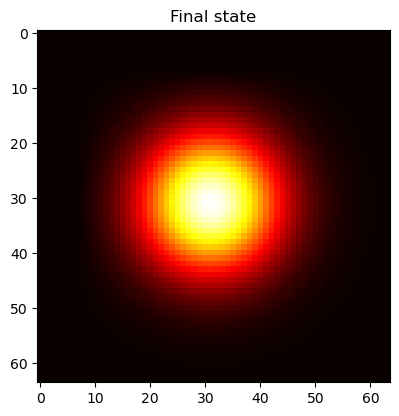

In [44]:
# Plot the results
using PyPlot
fig = figure(figsize=(10, 10))

# Plot the final state
subplot(121)
imshow(c_out[:, :, N ÷ 2], cmap="hot", interpolation="none")
title("Final state")
gcf()